# Live Daten Montag bis Sonntag

In [1]:
from __future__ import unicode_literals
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import common.live

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
LIVE_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/live'

## Live Daten
___

In [3]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

#create additional column
live['day'] = live.index.strftime('%Y-%m-%d')
live['weekday'] = live.index.dayofweek

## Auswertung 
___

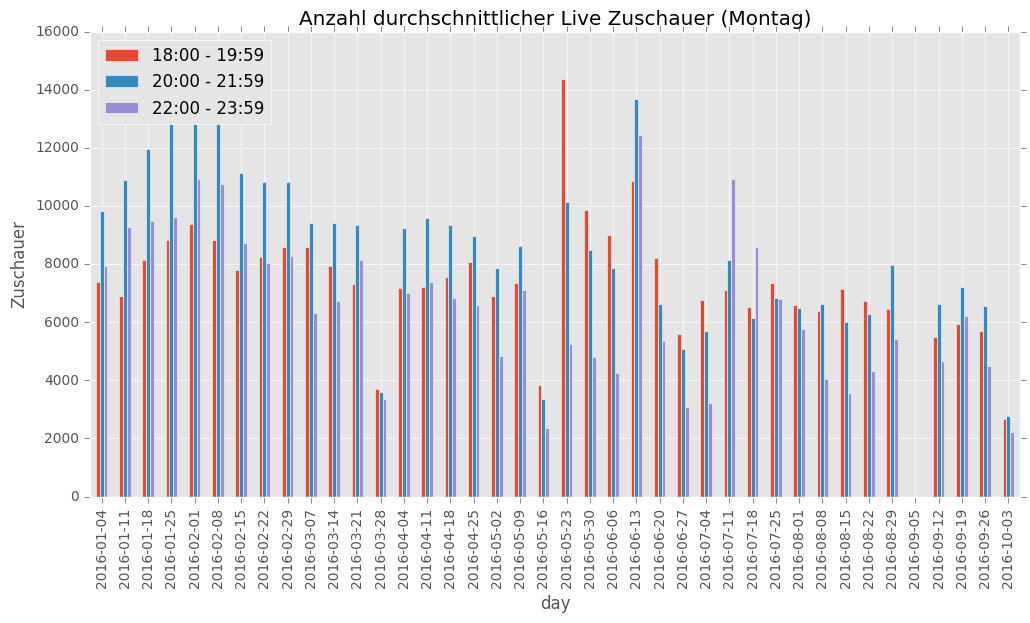

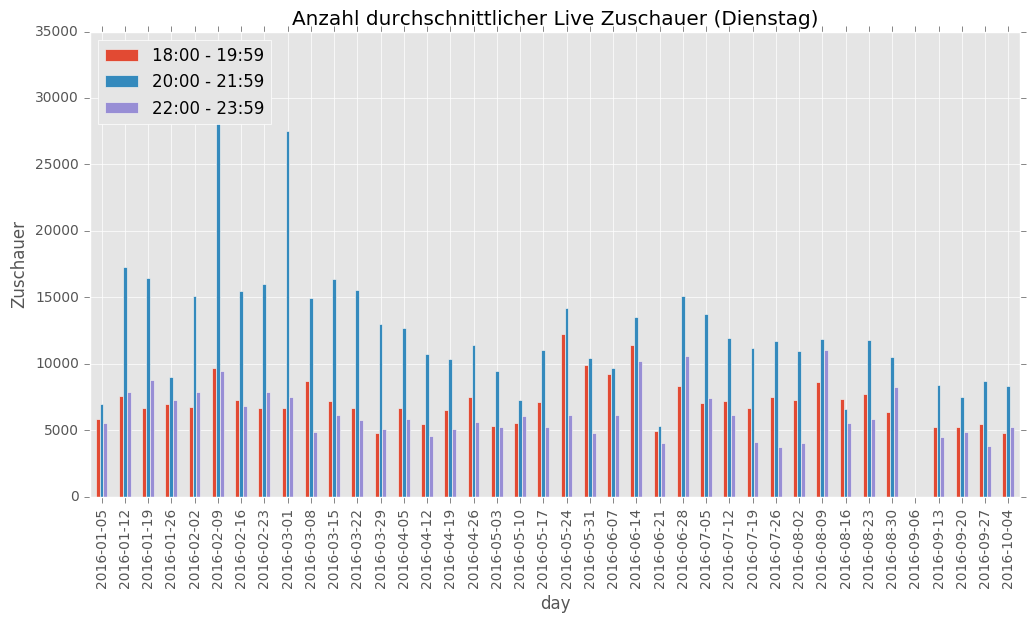

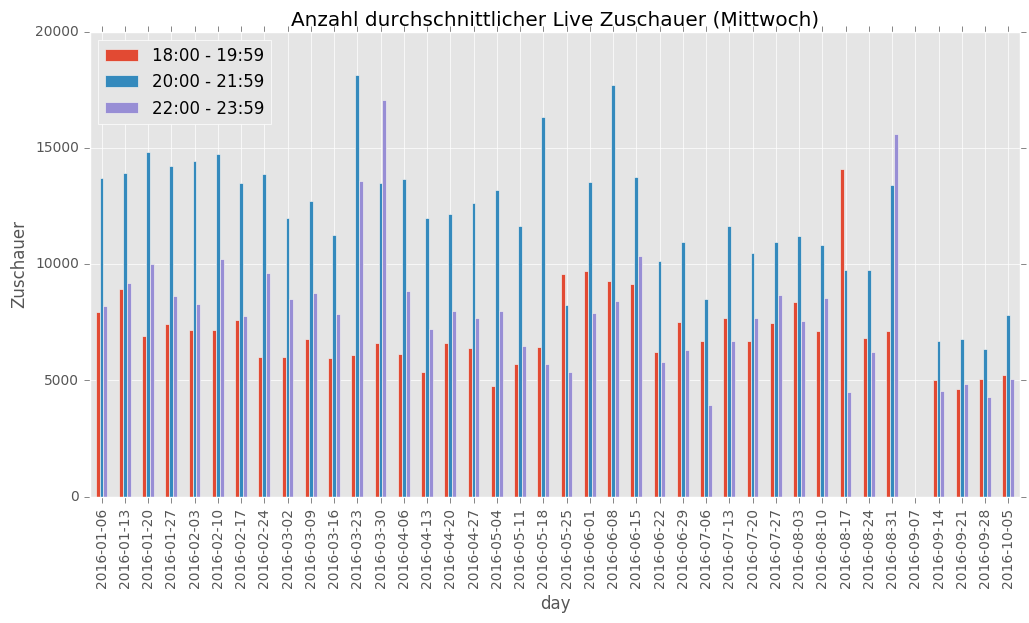

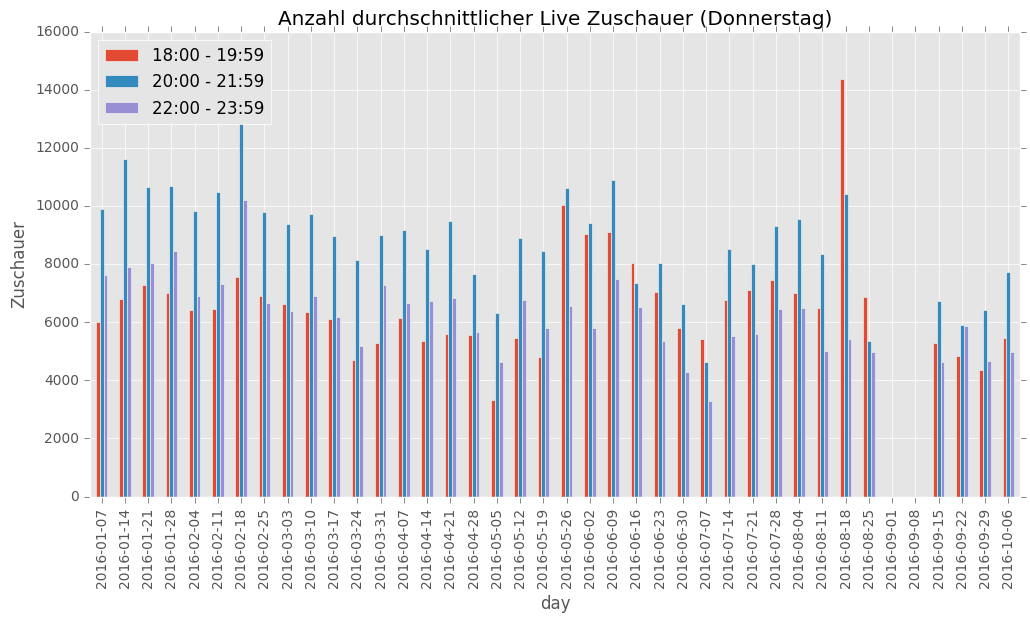

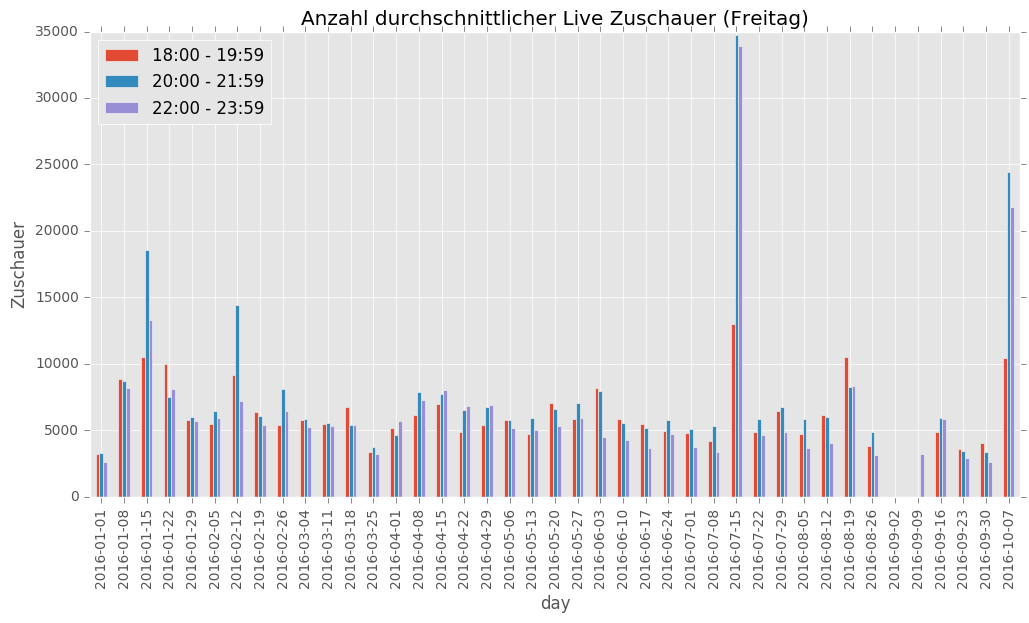

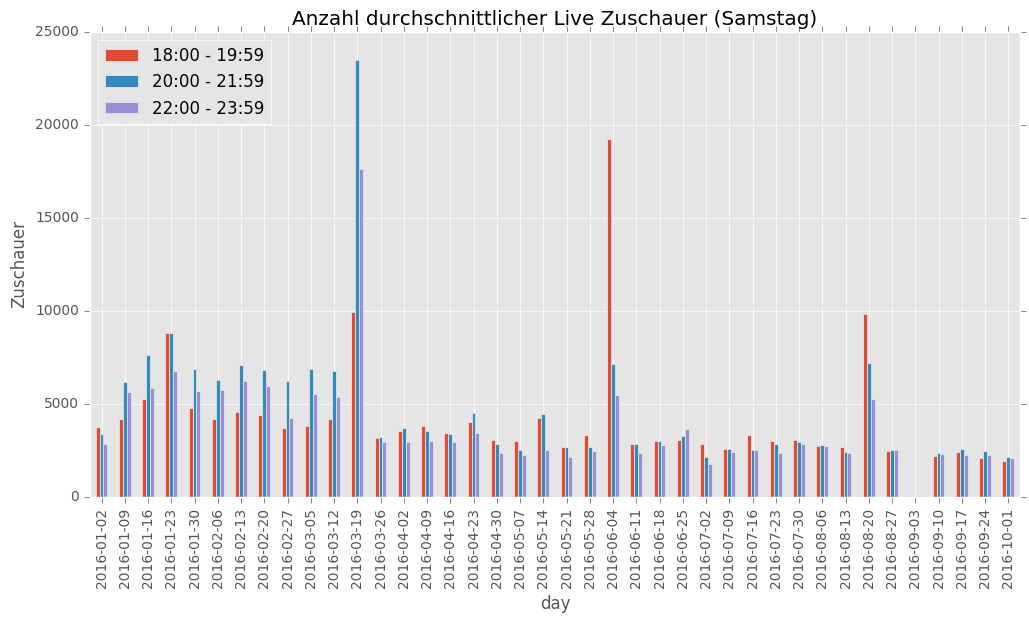

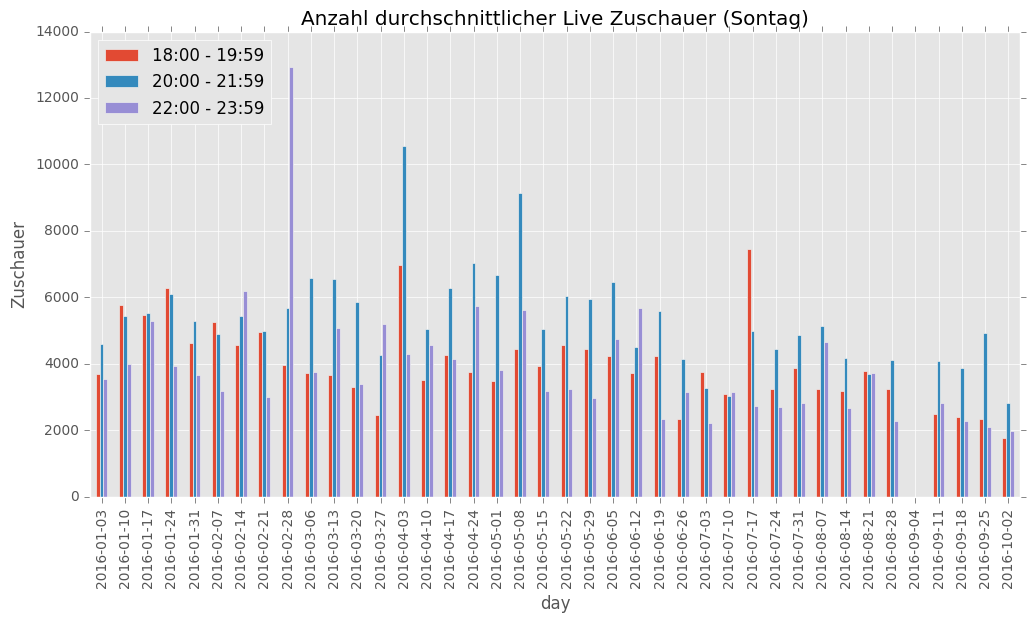

In [4]:
#filter data by date
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime.now()
liveFiltered = live.loc[start : end]

weekdayNames = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sontag']

dataMonthly = []
for i in range(0, 7):
    #filter data by weekday
    liveFilteredWeekday = liveFiltered[liveFiltered['weekday'] == i]
    
    dataMonthly.append({})

    #filter data by time
    rangeStart = datetime.time(18, 0, 0)
    rangeEnd = datetime.time(19, 59, 59)
    until = datetime.time(0, 0, 0)
    data = pd.DataFrame({})
    for j in range(0, 3):
        rangeStr = rangeStart.strftime('%H:%M') + ' - ' + rangeEnd.strftime('%H:%M')

        dataMonthly[i][rangeStr] = pd.DataFrame()

        #filter data by time
        liveFilteredTime = liveFilteredWeekday.between_time(rangeStart, rangeEnd)

        #group messages by date
        liveGrouped = liveFilteredTime.groupby('day')

        #filter groups by minimum number of datapoints
        liveGrouped = liveGrouped.filter(lambda group: len(group) > 25)

        #group messages by date
        liveGrouped = liveGrouped.groupby('day')

        #calculate mean for each day
        liveMean = liveGrouped.apply(lambda group: group['viewers'].mean())

        data[rangeStr] = liveMean
        
        #group monthly
        liveMean = liveMean.to_frame('viewers')
        liveMean = liveMean.set_index(pd.to_datetime(liveMean.index, format='%Y-%m-%d'))
        liveGrouped = liveMean.groupby(liveMean.index.strftime('%Y-%m'))
        
        #add monthly data
        for g, d in liveGrouped:
            d = d['viewers'].tolist()
            d += [float('NaN')] * (5 - len(d))
            dataMonthly[i][rangeStr][g] = d

        #add 2 hours
        rangeStart = (datetime.datetime.combine(datetime.date.today(), rangeStart) + datetime.timedelta(hours=2)).time()
        rangeEnd = (datetime.datetime.combine(datetime.date.today(), rangeEnd) + datetime.timedelta(hours=2)).time()

    #plot
    plot = data.plot(kind='bar', figsize=(12, 6), title='Anzahl durchschnittlicher Live Zuschauer (%s)' % weekdayNames[i])
    plot.set_ylabel('Zuschauer')

    legend = plot.legend(loc=2)

    plt.ylim(ymin=0)

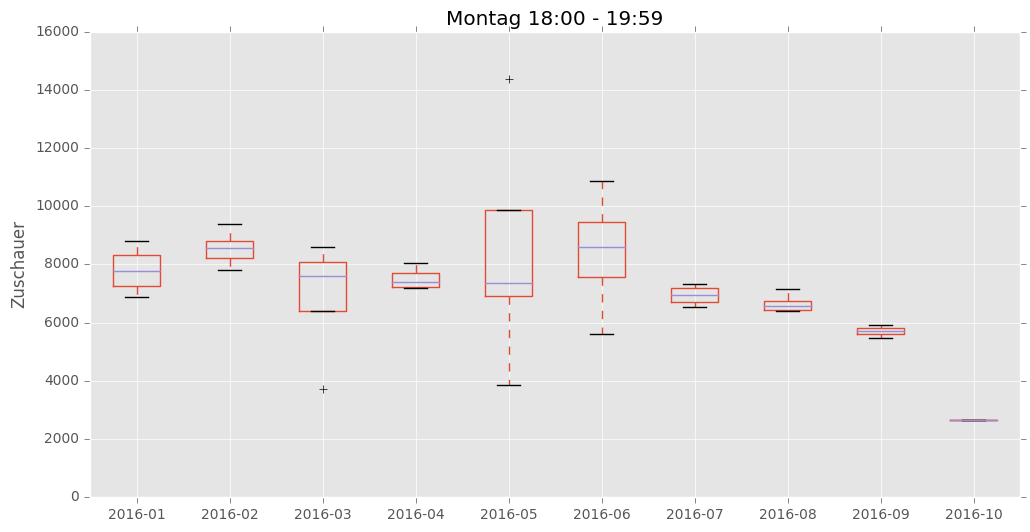

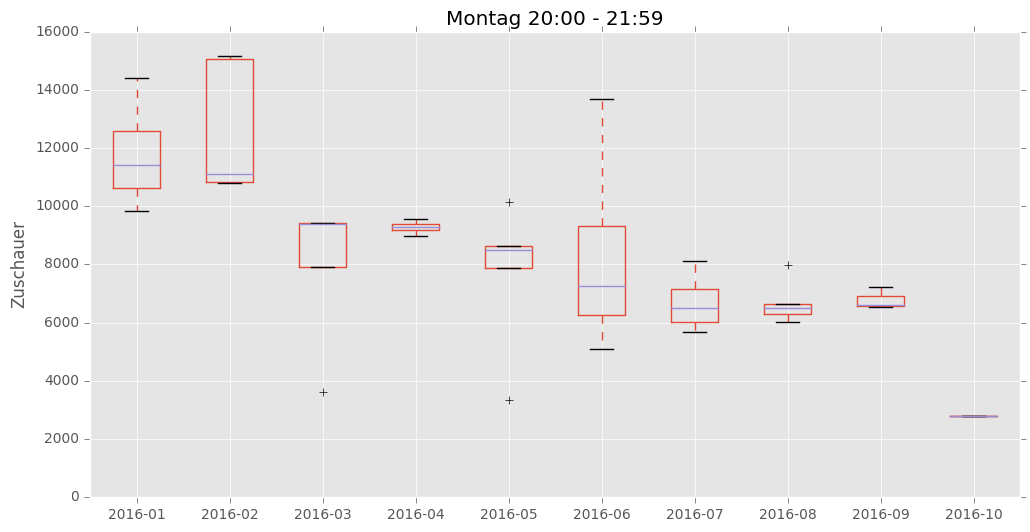

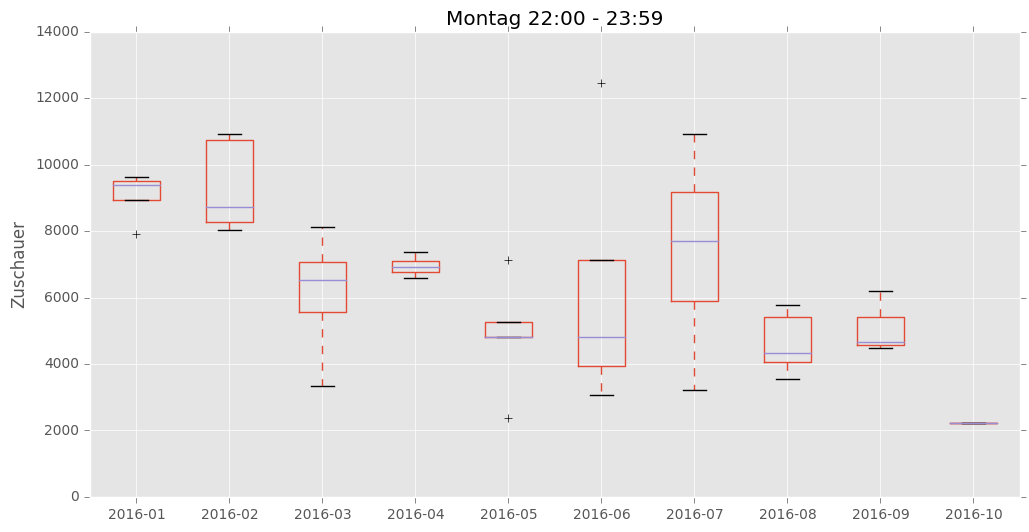

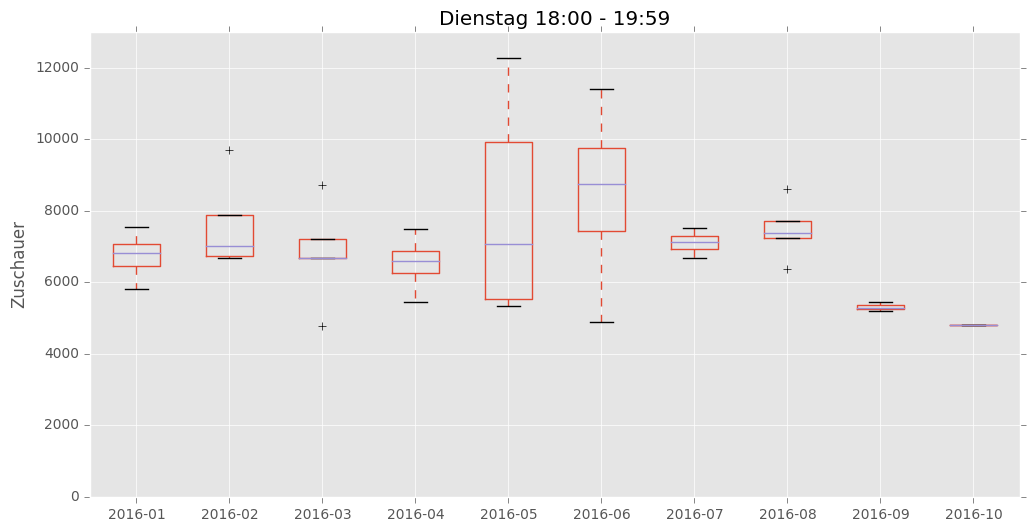

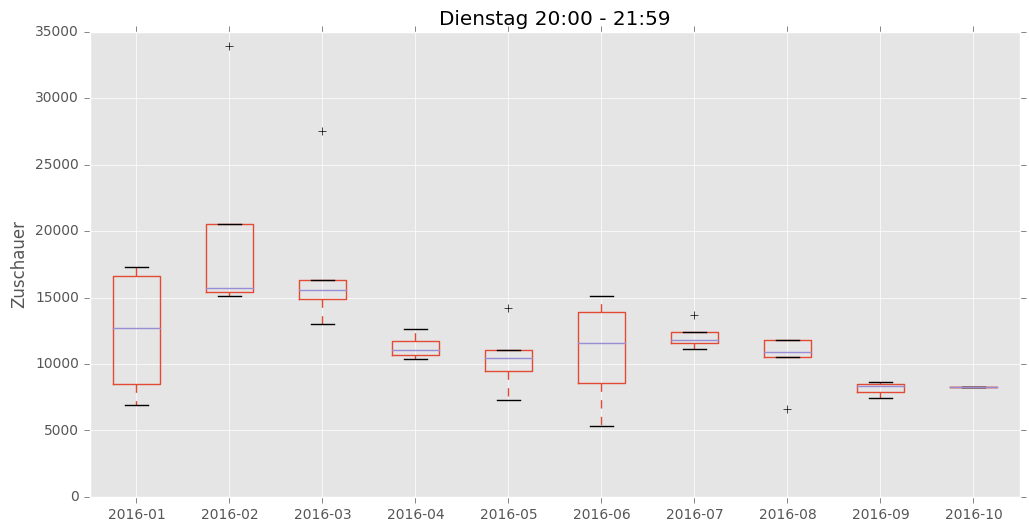

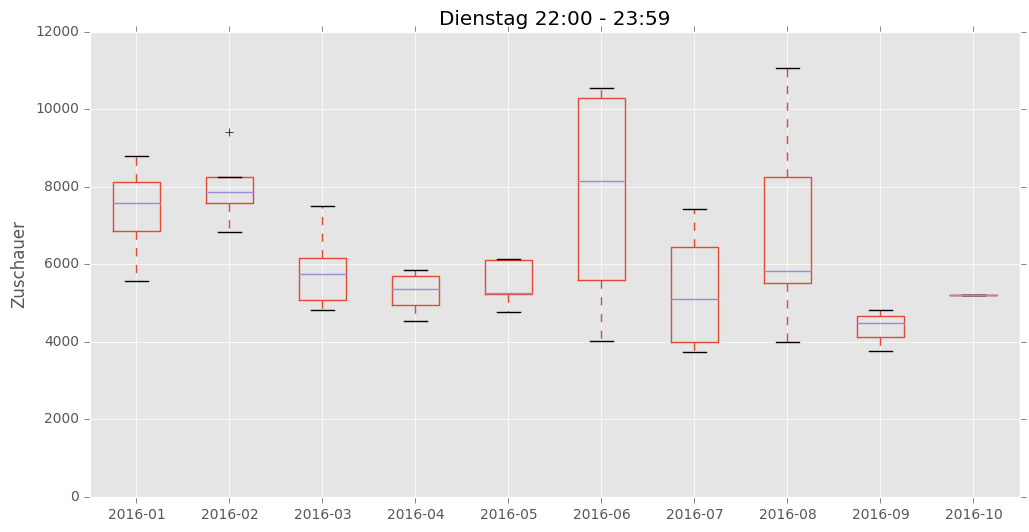

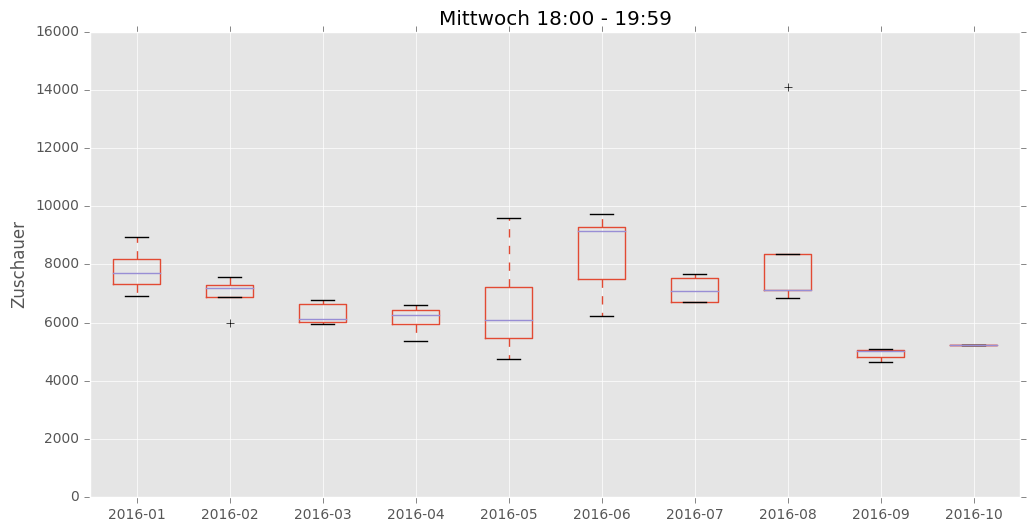

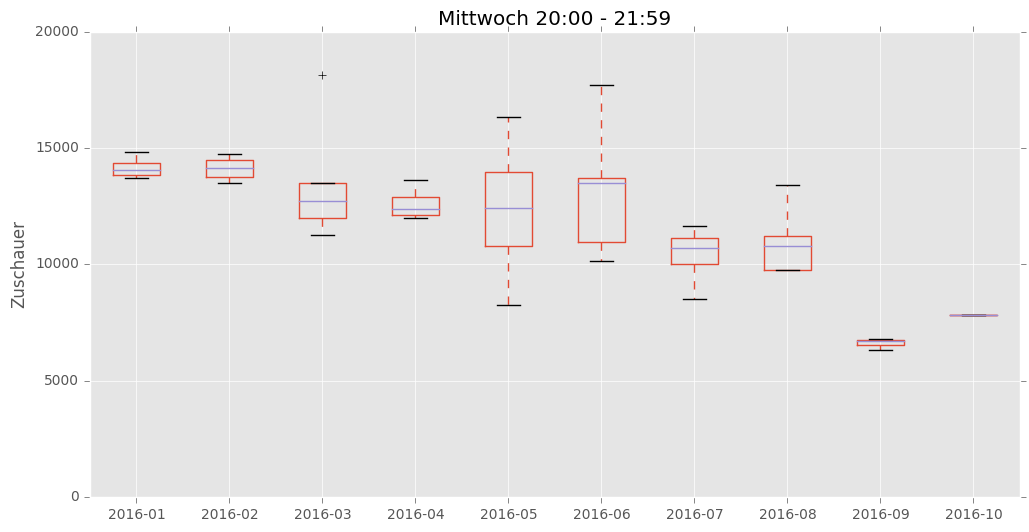

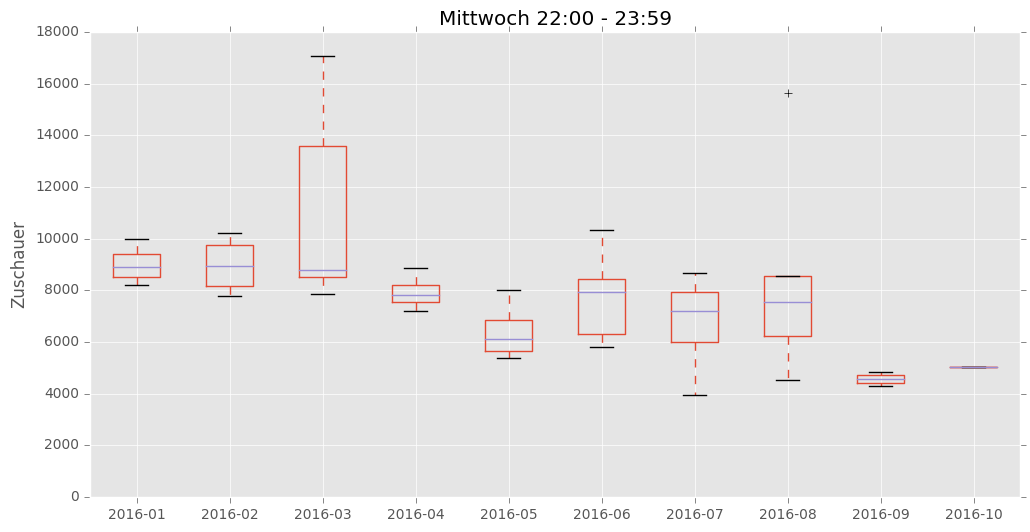

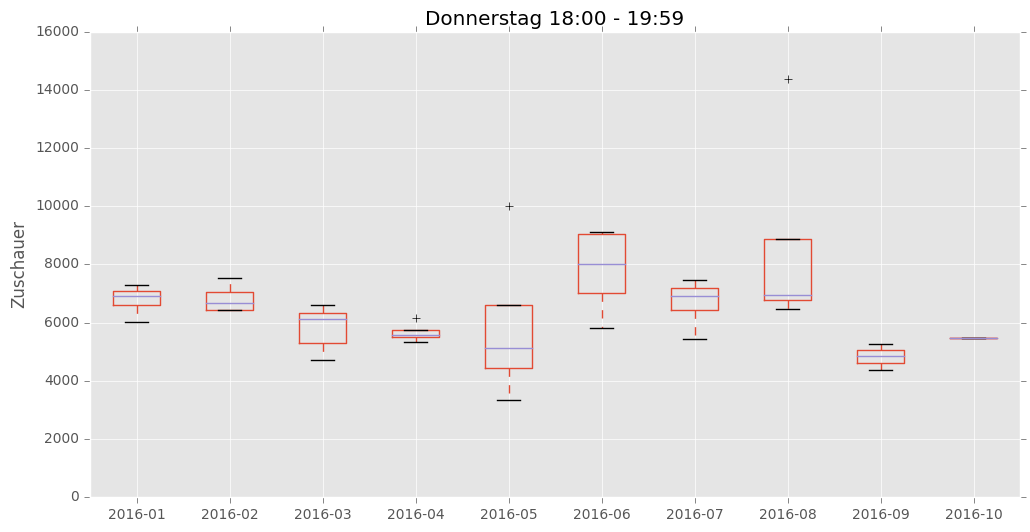

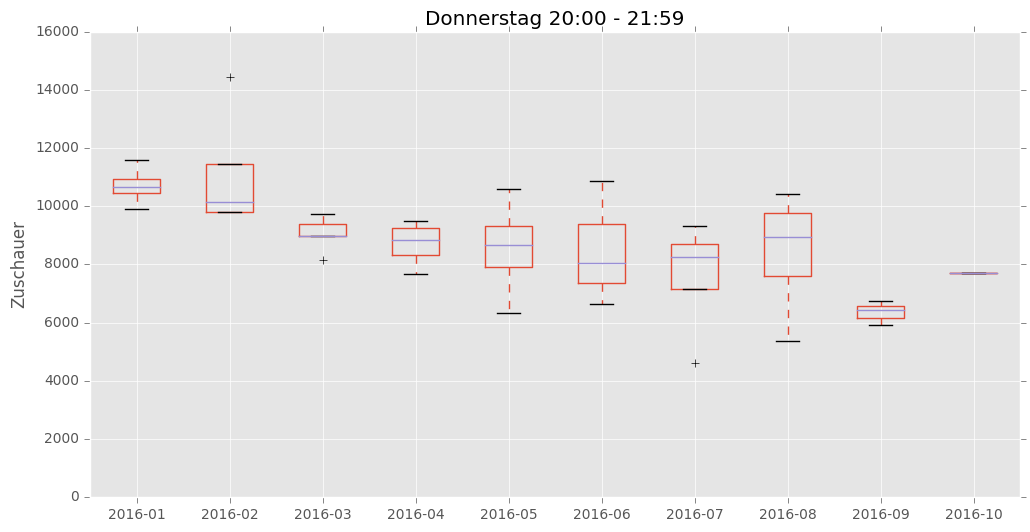

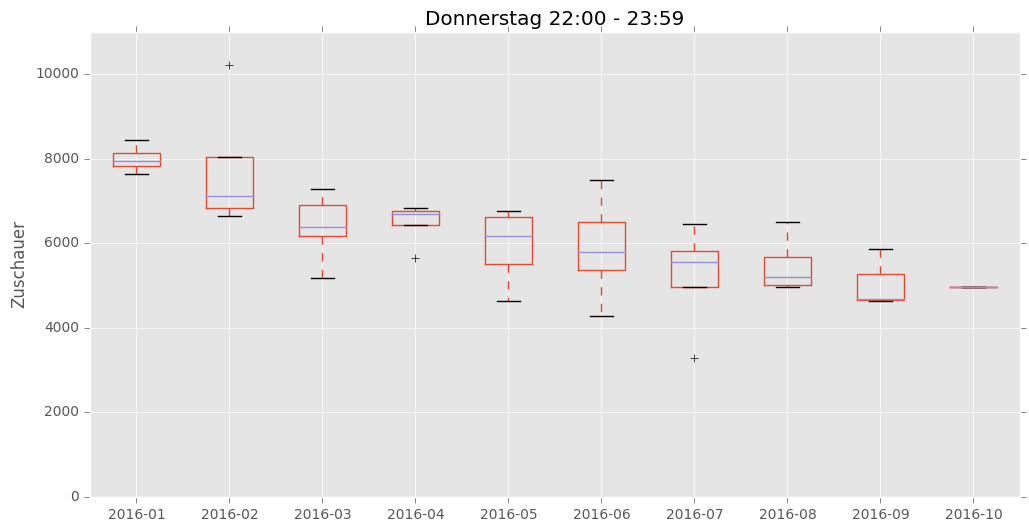

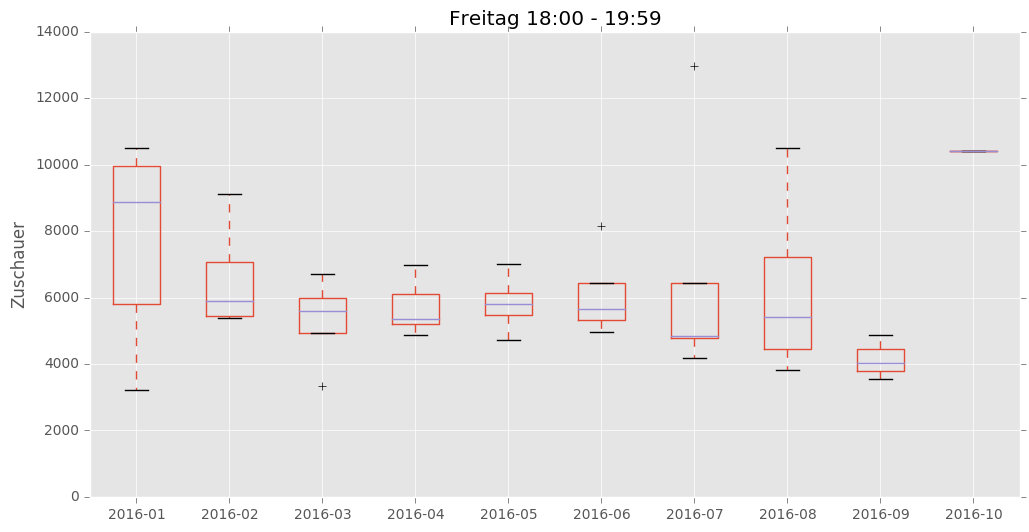

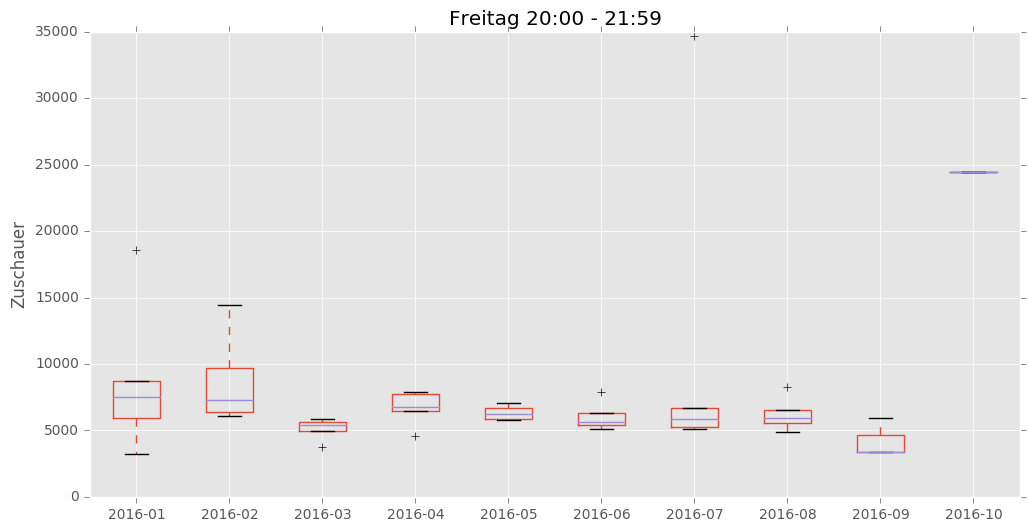

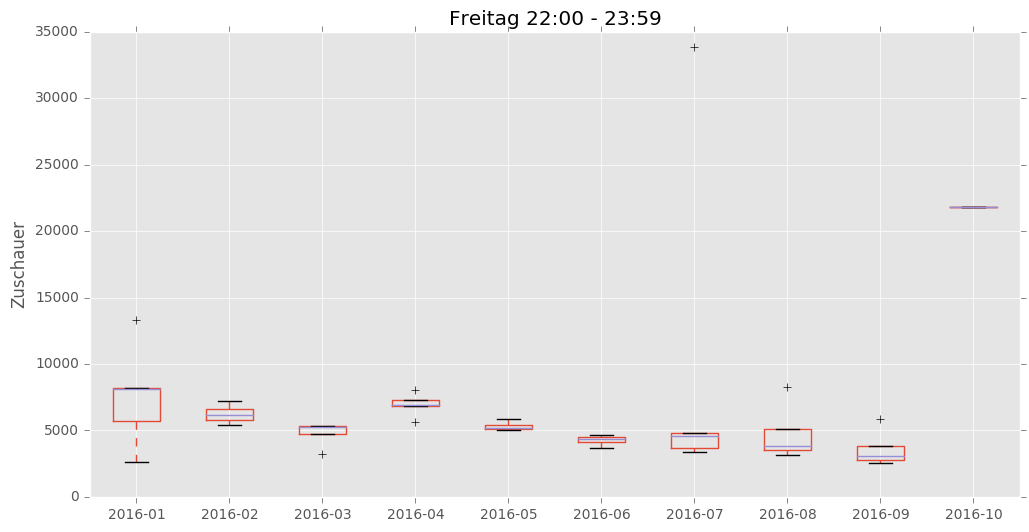

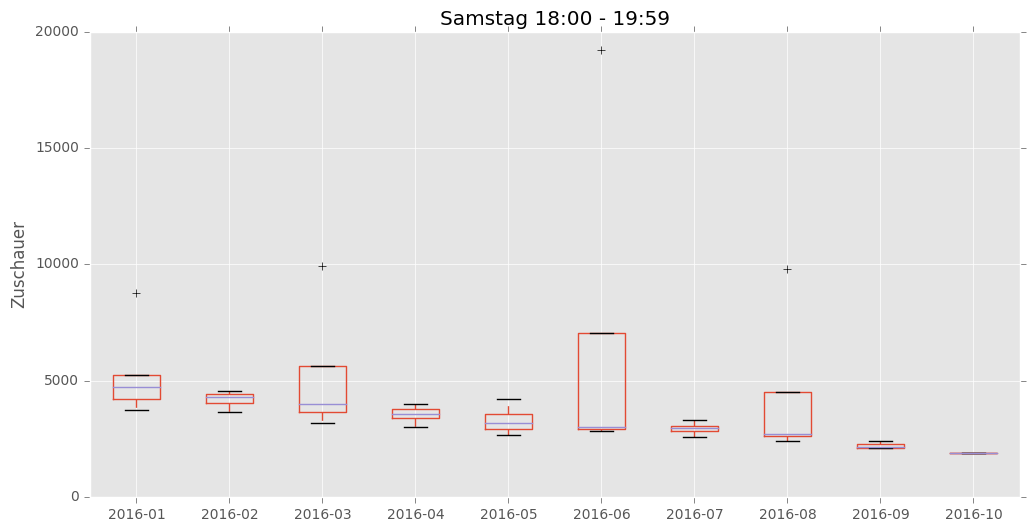

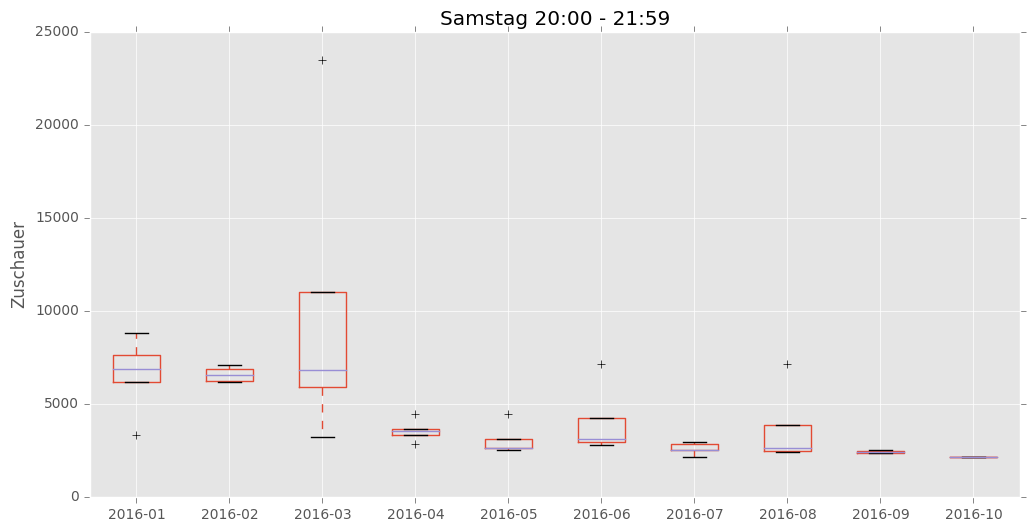

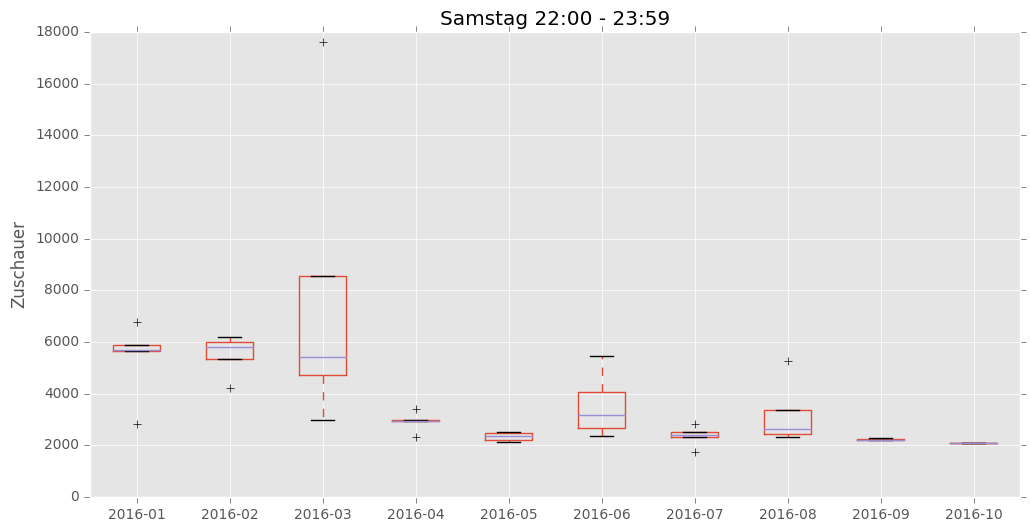

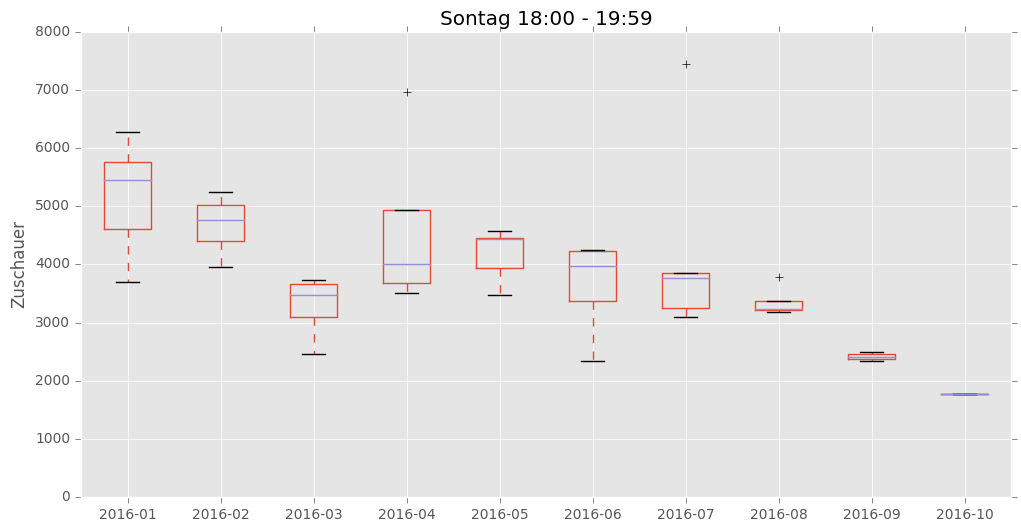

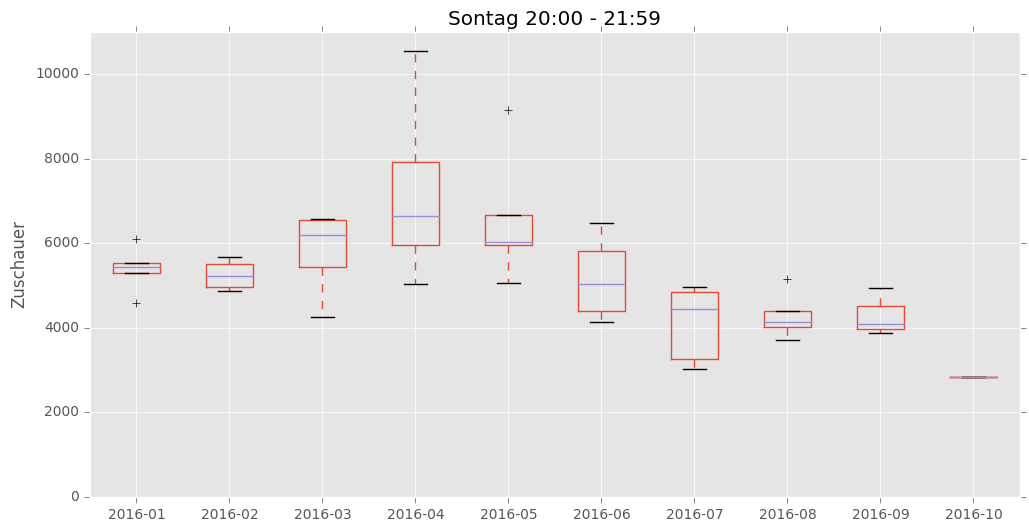

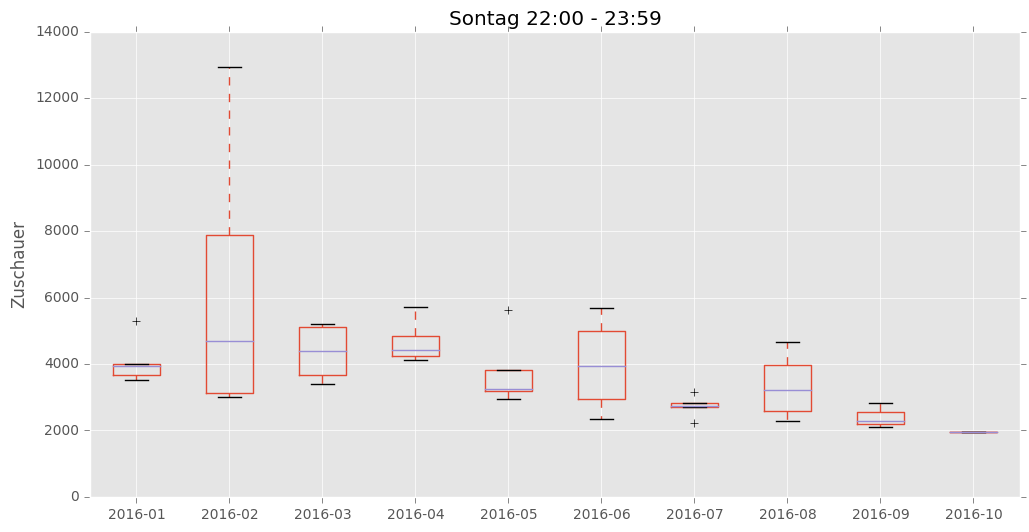

In [5]:
for i, value in enumerate(dataMonthly):
    weekdayStr = weekdayNames[i]
    for timeStr, data in sorted(value.iteritems()):
        plot = data.plot(kind='box', figsize=(12, 6), title='%s %s' % (weekdayStr, timeStr))
        plot.set_ylabel('Zuschauer')
        plt.ylim(ymin=0)